In [1]:
import matplotlib.pyplot as plt
import scgenome.plotting as pl
import anndata
plot_size = (8, 4)
plot_dpi = 300

In [2]:
# file_path = "/Users/zemp/phd/scilife/mskcc_data/MM_GEO/patient_MM-03.h5ad"
# file_path = "/Users/zemp/PycharmProjects/victree/datasets/simul_k5a7n300m2012e50-4000d5mt1-2000-500-50.h5ad"
data_path = "../../datasets/SA501X3F.h5ad"
in_ad = anndata.read_h5ad(data_path)
victree_out11 = "../../out_SA501X3F_K11/victree.out.h5ad"
victree_out = "../../out_SA501X3F_K12/victree.out.h5ad"
victree_out13 = "../../out_SA501X3F_K13/victree.out.h5ad"
ad = anndata.read_h5ad(victree_out)
ad.obs_keys(), ad.layers.keys(), ad.uns_keys()

/home/zemp/opt/miniconda3/envs/victree-env/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(['victree-mu',
  'victree-mt-lambda',
  'victree-mt-alpha',
  'victree-mt-beta',
  'victree-tau',
  'victree-clone',
  'victree-loglik'],
 KeysView(Layers with keys: victree-cn-marginal, victree-cn-viterbi),
 ['victree-elbo',
  'victree-eps-alpha',
  'victree-eps-beta',
  'victree-tree-graph',
  'victree-tree-newick',
  'victree-tree-probs'])

In [3]:
import pandas as pd
con_cn_df = pd.read_csv("/home/zemp/scilife/victree/datasets/CONSET_CNs_SA501X3F.csv")
cell_names = con_cn_df.filter(like='SA501X3F').columns
in_ad.layers['conet-cn'] = con_cn_df[cell_names].to_numpy().T

## VICTree K=12

In [4]:
import h5py
clone_probs = None
import numpy as np

with h5py.File("../../out_SA501X3F_K12/victree.model.h5", 'r') as fk12:
    clone_probs = fk12['qZ']['pi'][...]

ad.obs['clone-prob'] = clone_probs[np.arange(ad.n_obs), ad.obs['victree-clone']]
in_ad.obs['clone-prob'] = clone_probs[np.arange(ad.n_obs), ad.obs['victree-clone']]


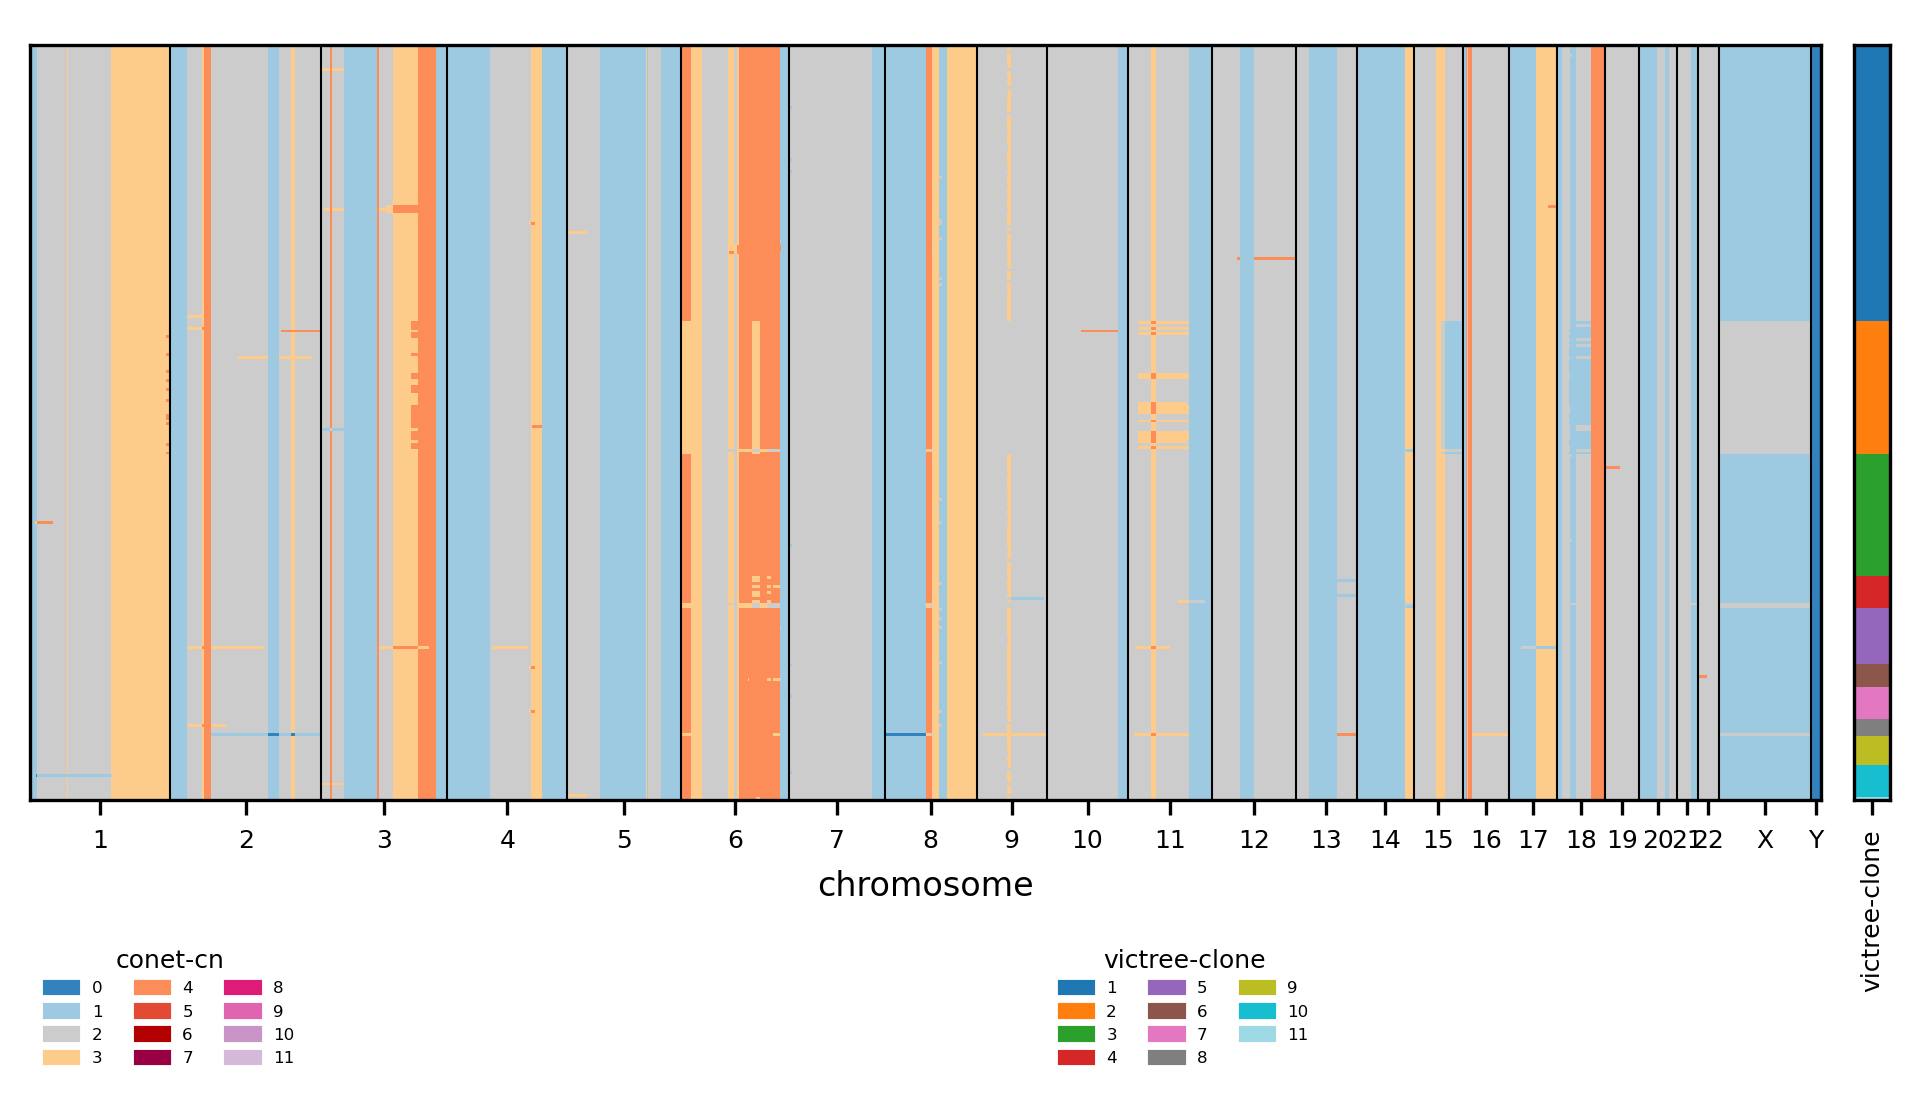

In [6]:
in_ad.obs['victree-clone'] = ad.obs.set_index(in_ad.obs_names)['victree-clone']
g = pl.plot_cell_cn_matrix_fig(in_ad, 'conet-cn', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'])
gfig = g['fig']
gfig.set_size_inches(*plot_size)
gfig.set_dpi(plot_dpi)
gfig.savefig("../../out_SA501X3F_K12/conet_cn.png")

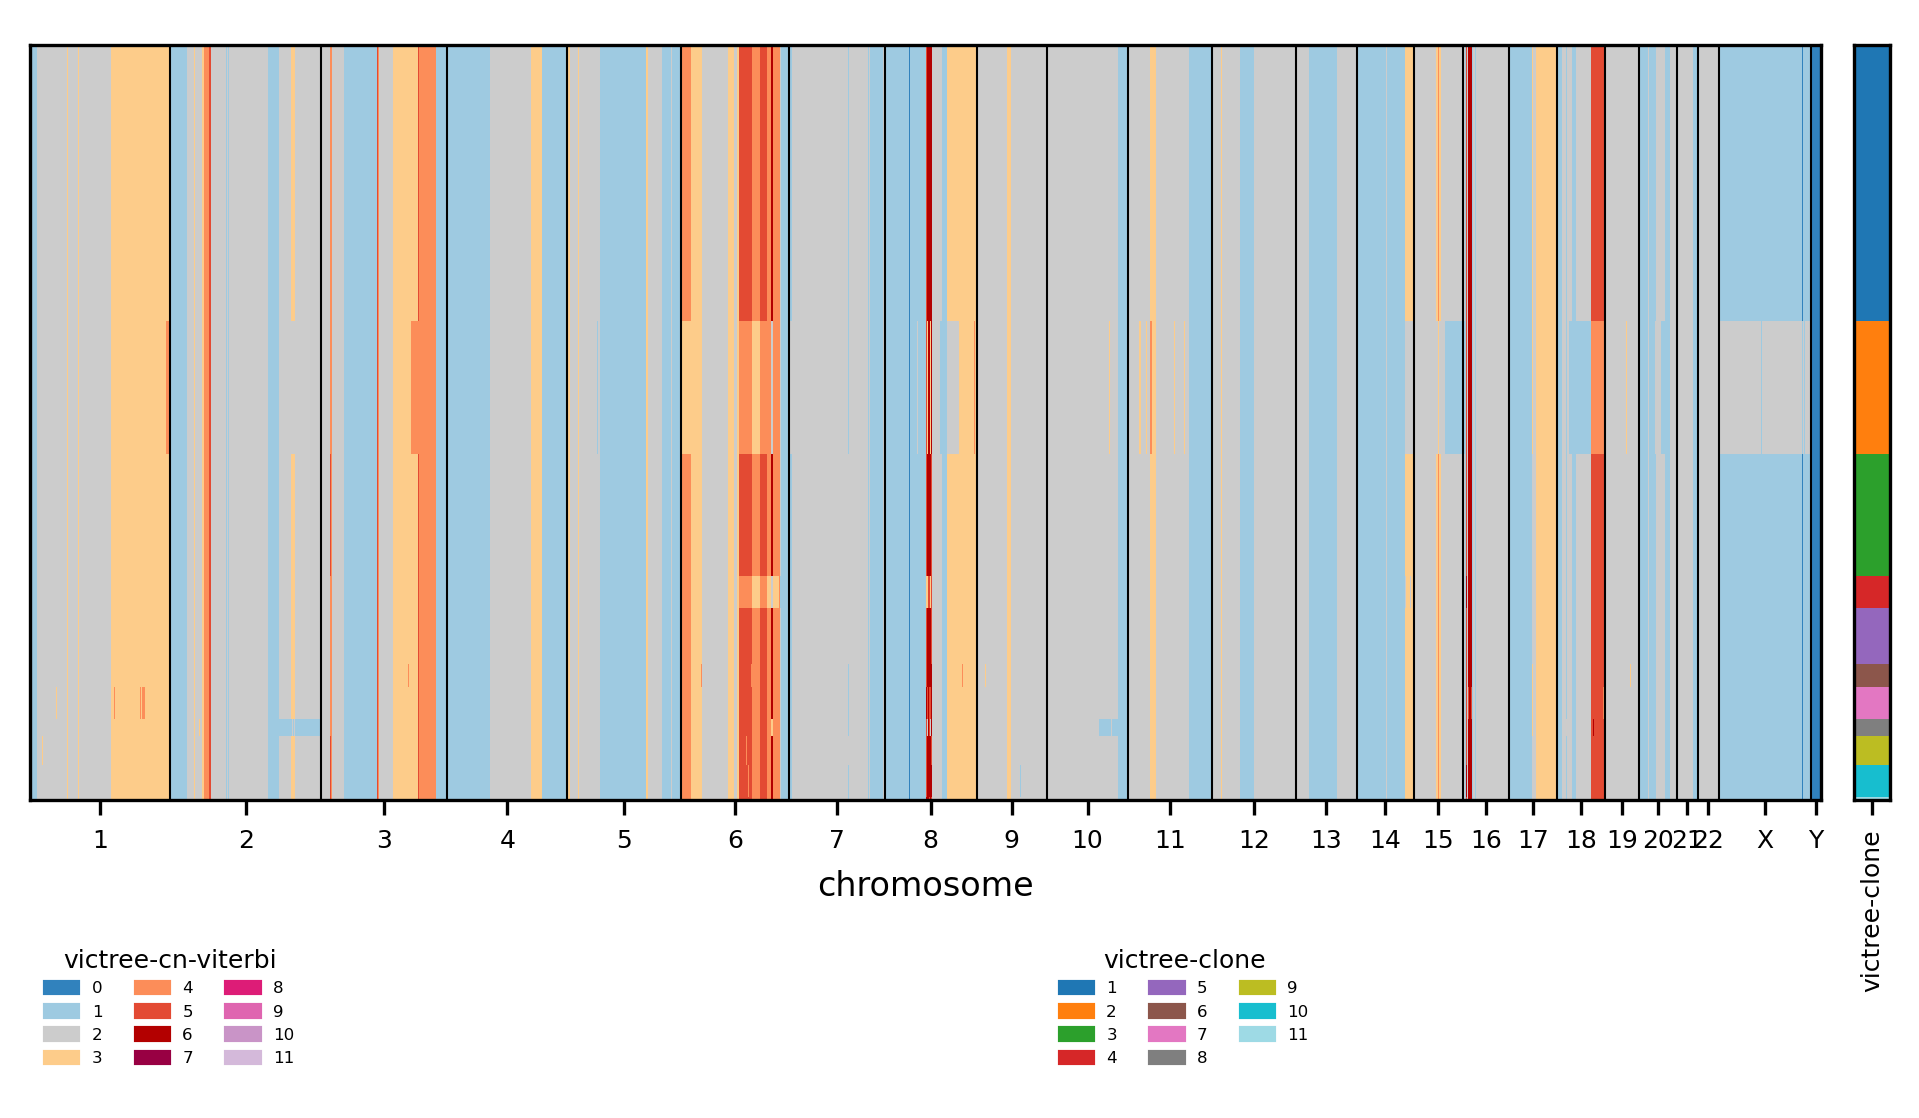

In [7]:
g = pl.plot_cell_cn_matrix_fig(ad, 'victree-cn-viterbi', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'])

gfig = g['fig']
gfig.set_size_inches(*plot_size)
gfig.set_dpi(plot_dpi)
gfig.savefig("../../out_SA501X3F_K12/victree_cn.png")

[b'((((10)6,7,8)1,2,(9)3,4,11)5)0' b'(((2,(10)6,7,8)1,(9)3,4,11)5)0']
[nan nan]
(((2,(10)6,7,8)1,(9)3,4,11)5)0
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([95, 46, 42, 11, 19,  8, 11,  6, 10, 11,  1]))


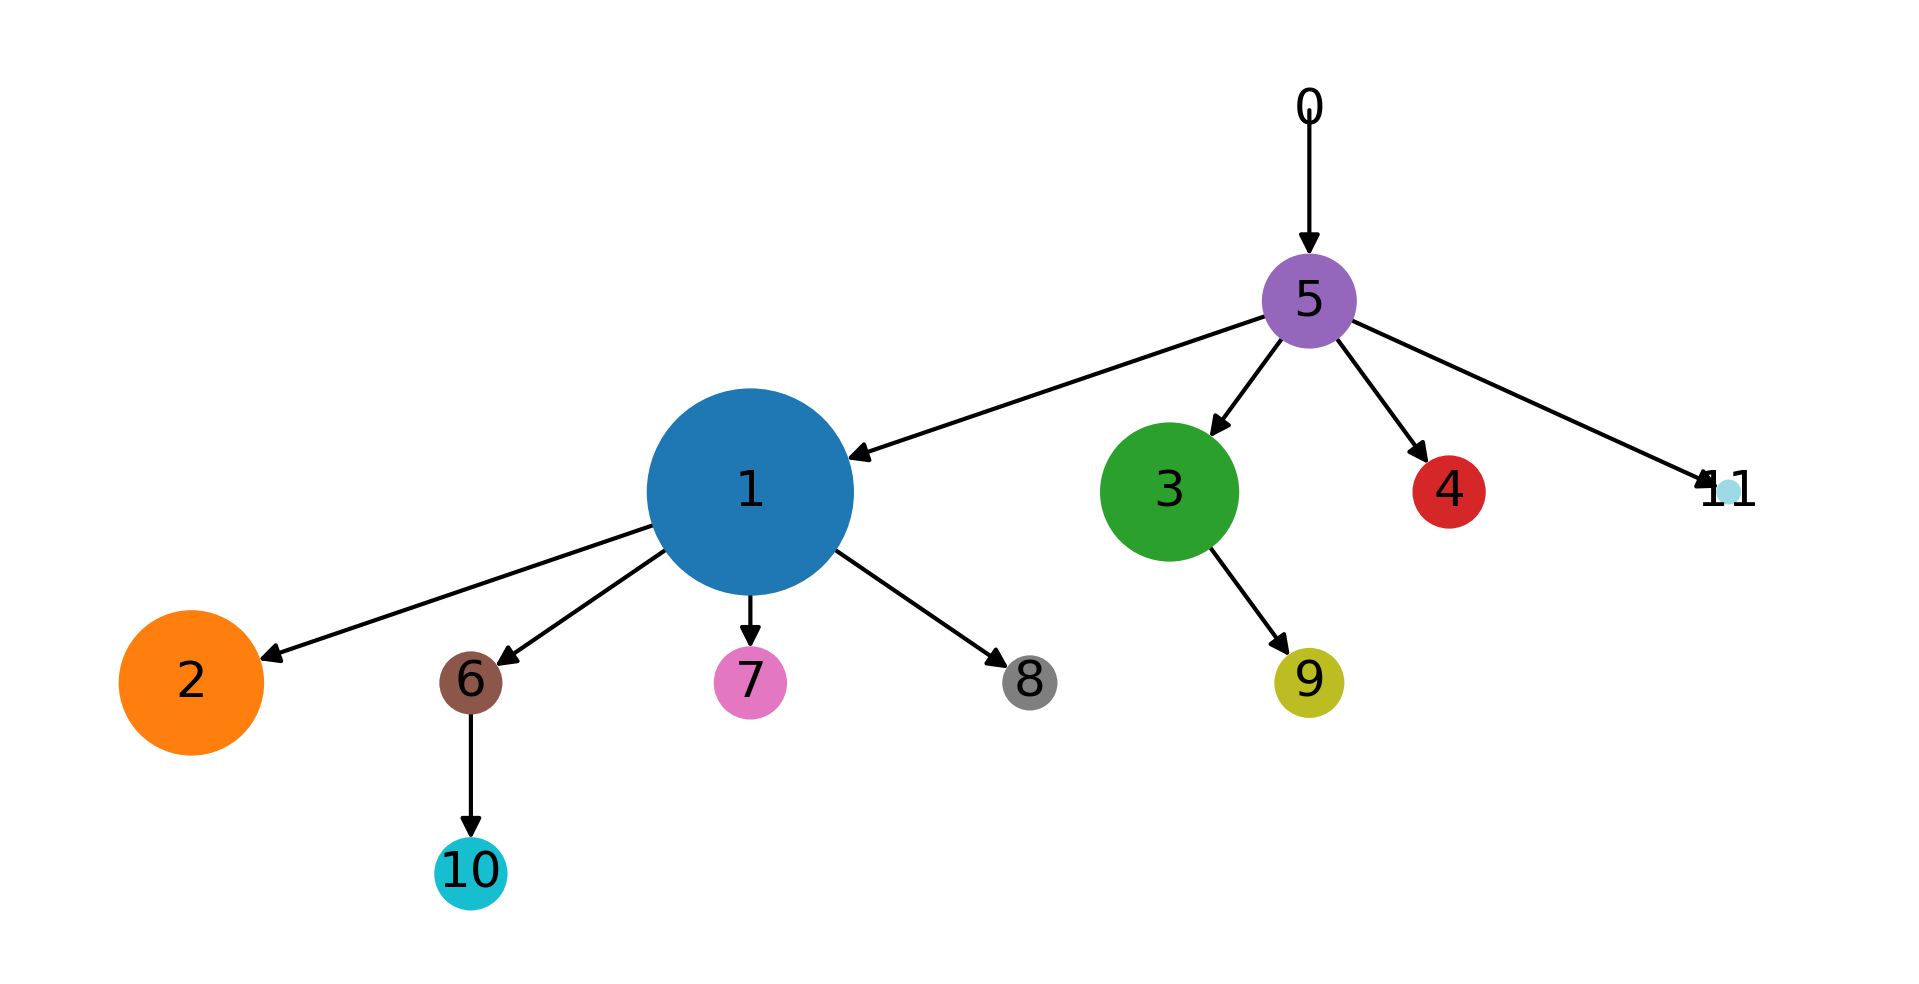

In [10]:
from io import StringIO
from utils.tree_utils import parse_newick, tree_to_newick
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import numpy as np

print(ad.uns['victree-tree-newick'])
print(ad.uns['victree-tree-probs'])
tree_newick =str(ad.uns['victree-tree-newick'][1], 'UTF-8')
print(tree_newick)
tree = parse_newick(StringIO(tree_newick))
tree = nx.relabel_nodes(tree, {str(i): i for i in range(len(tree.nodes()))})
pos = graphviz_layout(tree, prog='dot')
col_dict = g['annotation_info']['victree-clone']['level_colors']
col_dict[0] = np.array([189, 195, 199, 1.]) / np.array([255, 255, 255, 1.])
colors = [col_dict[i] for i in tree.nodes()]
clone_counts = np.unique(ad.obs['victree-clone'], return_counts=True)
print(clone_counts)
node_size_dict = {a[0]: a[1] for a in zip(*clone_counts)}
node_size_dict[0] = 0
node_size = [node_size_dict[i] * 25 for i in tree.nodes()]
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
nx.draw(tree, node_color=colors, with_labels=True, pos=pos, node_size=node_size)
fig.savefig("../../out_SA501X3F_K12/treeplot.png")

0.045493598560998834


TypeError: plot_cell_cn_matrix_fig() missing 1 required positional argument: 'adata'

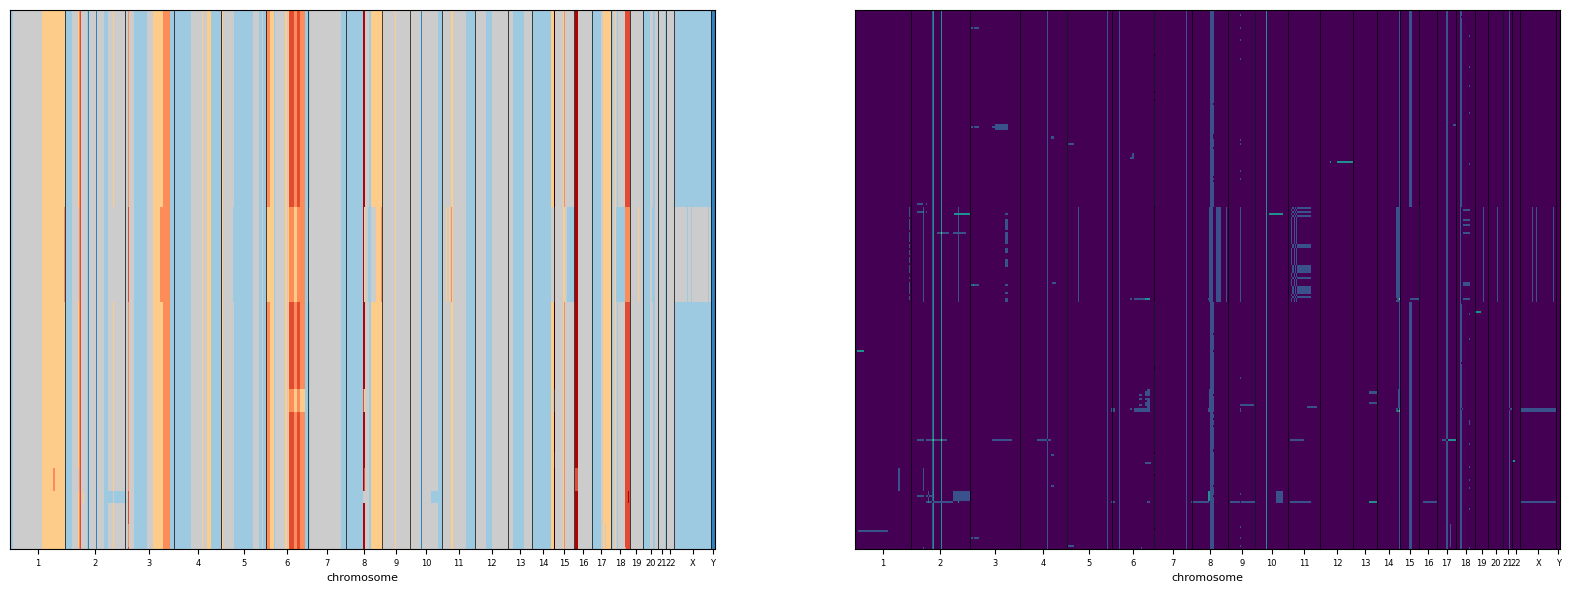

In [43]:
import matplotlib.pyplot as plt
ad.layers['diff-cn'] = np.abs(np.clip(ad.layers['victree-cn-viterbi'], a_min=0, a_max=4)-in_ad.layers['conet-cn'])
print(np.mean(ad.layers['diff-cn']))
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
h = pl.plot_cell_cn_matrix(ad, 'victree-cn-viterbi', cell_order_fields=['victree-clone'], max_cn=6, ax=axs[0])
f = pl.plot_cell_cn_matrix(ad, 'diff-cn', cell_order_fields=['victree-clone'], raw=True, ax=axs[1])

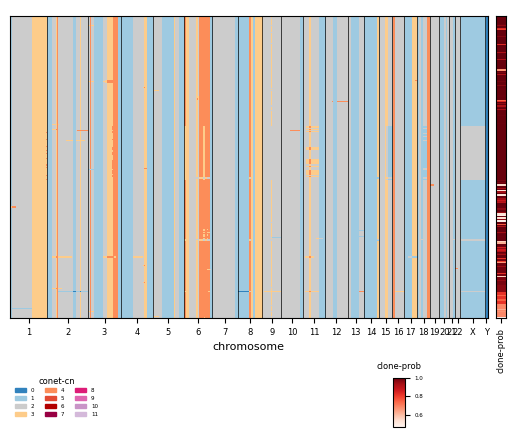

In [46]:

pp = pl.plot_cell_cn_matrix_fig(in_ad, 'conet-cn', cell_order_fields=['victree-clone'], annotation_fields=['clone-prob'],)


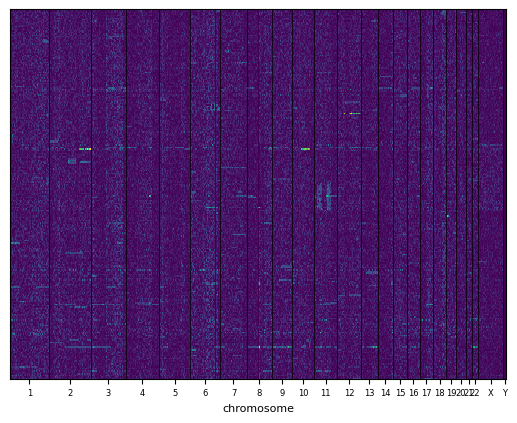

In [23]:
ad.layers['diff-counts'] = np.abs(ad.layers['victree-cn-viterbi']-in_ad.layers['copy'])
f = pl.plot_cell_cn_matrix(ad, 'diff-counts', cell_order_fields=['victree-clone'], raw=True)

## VICTree K=13

In [7]:
# import h5py
# from utils.evaluation import best_vi_map
#
# viz12 = None
# viz13 = None
# with h5py.File("../../out_SA501X3F_K12/victree.model.h5") as f:
#     viz12 = f['qZ']['pi'][...]
# with h5py.File("../../out_SA501X3F_K13/victree.model.h5") as f:
#     viz13 = f['qZ']['pi'][...]
#
# map_k13_to_k12 = best_vi_map(viz13, viz12)

/home/zemp/opt/miniconda3/envs/victree-env/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


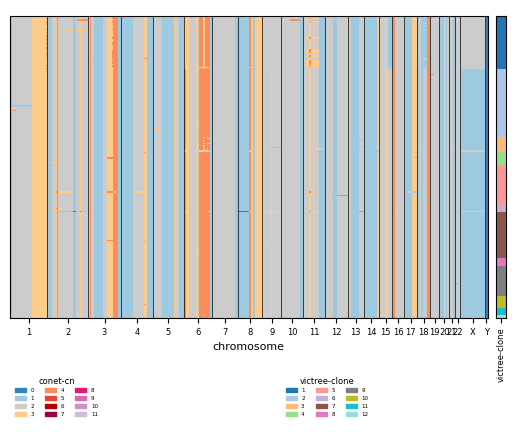

In [8]:
ad13 = anndata.read_h5ad(victree_out13)
in_ad.obs['victree-clone'] = ad13.obs.set_index(in_ad.obs_names)['victree-clone']
g = pl.plot_cell_cn_matrix_fig(in_ad, 'conet-cn', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'])

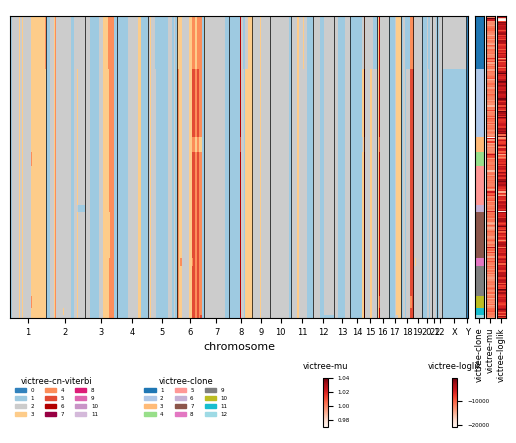

In [9]:
g = pl.plot_cell_cn_matrix_fig(ad13, 'victree-cn-viterbi', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone', 'victree-mu', 'victree-loglik'])


[b'((((10)6,7,8)1,2,(9)3,4,11)5)0' b'(((2,(10)6,7,8)1,(9)3,4,11)5)0']
[nan nan]
((2,3,(4,(1,11)7,8,(10)9)5,12)6)0


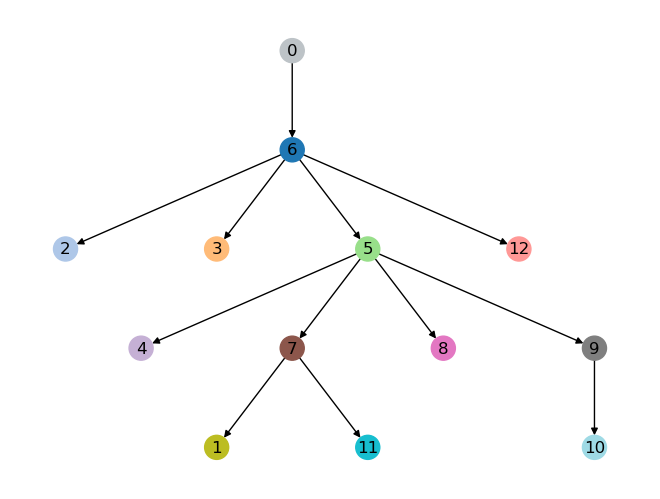

In [10]:
print(ad.uns['victree-tree-newick'])
print(ad.uns['victree-tree-probs'])
tree_newick =str(ad13.uns['victree-tree-newick'][0], 'UTF-8')
print(tree_newick)
tree = parse_newick(StringIO(tree_newick))
pos = graphviz_layout(tree, prog='dot')
node_color = [np.array([189, 195, 199, 1.]) / np.array([255, 255, 255, 1.])] + list(g['annotation_info']['victree-clone']['level_colors'].values())
nx.draw(tree, node_color=node_color, with_labels=True, pos=pos)

In [10]:
# ad.write_csvs("/Users/zemp/PycharmProjects/victree/datasets/corr_reads.csv")

## VICTree K=11

/home/zemp/opt/miniconda3/envs/victree-env/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


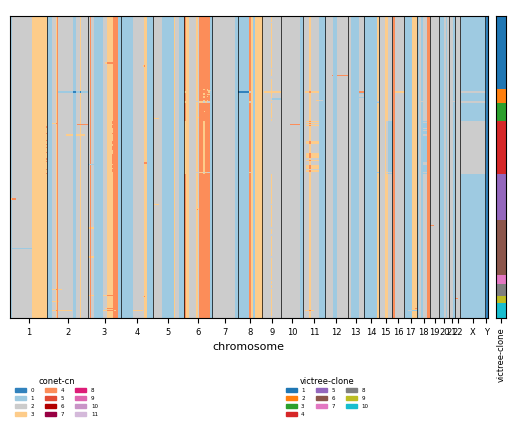

In [11]:
ad11 = anndata.read_h5ad(victree_out11)
in_ad.obs['victree-clone'] = ad11.obs.set_index(in_ad.obs_names)['victree-clone']
g = pl.plot_cell_cn_matrix_fig(in_ad, 'conet-cn', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'])

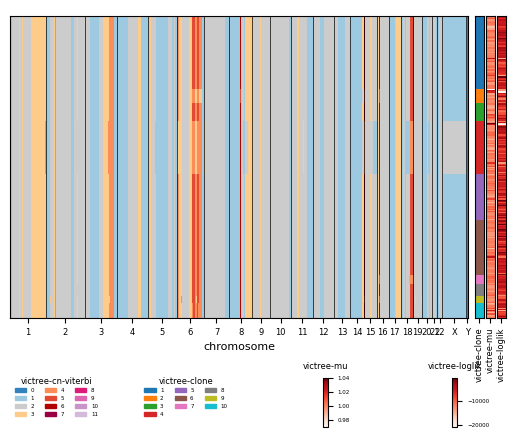

In [12]:
g = pl.plot_cell_cn_matrix_fig(ad11, 'victree-cn-viterbi', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone', 'victree-mu', 'victree-loglik'])


[b'((((10)6,7,8)1,2,(9)3,4,11)5)0' b'(((2,(10)6,7,8)1,(9)3,4,11)5)0']
[nan nan]
(((9)1,2,4,(3)5,6,7,10)8)0


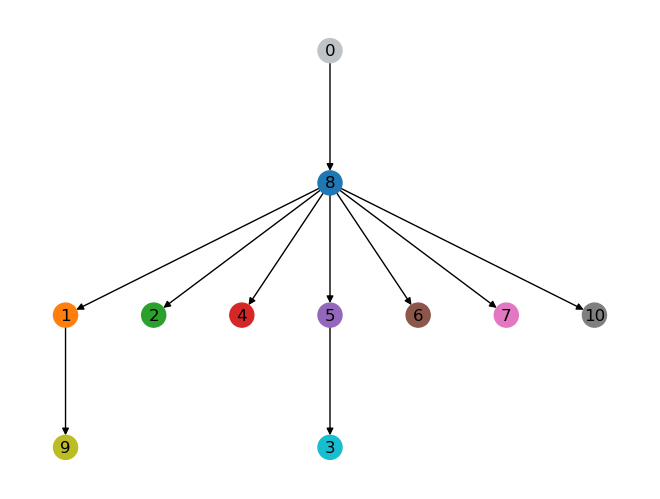

In [13]:
print(ad.uns['victree-tree-newick'])
print(ad.uns['victree-tree-probs'])
tree_newick =str(ad11.uns['victree-tree-newick'][0], 'UTF-8')
print(tree_newick)
tree = parse_newick(StringIO(tree_newick))
pos = graphviz_layout(tree, prog='dot')
node_color = [np.array([189, 195, 199, 1.]) / np.array([255, 255, 255, 1.])] + list(g['annotation_info']['victree-clone']['level_colors'].values())
nx.draw(tree, node_color=node_color, with_labels=True, pos=pos)

In [14]:
print(f"diff in elbo:\n\tK=11 {ad11.uns['victree-elbo']},\n\tK=12 {ad.uns['victree-elbo']},\n\tK=13 {ad13.uns['victree-elbo']}")

diff in elbo:
	K=11 -1607730.125,
	K=12 -1600238.0,
	K=13 -1596451.875
